In [1]:
from IPython.display import Image
from IPython.display import display, Markdown

# Solving the 6 colours happy cube
The happy cubes is a set of 6 puzzles where each puzzle comes in one colour -blue, green, yellow, orange, red and purple- and has 6 pieces. The pieces are basically square and each side has 5 'teeth', which can be either solid or empty. The pieces can be engaged to each other in a determined way to form a cube.
This notebook solves an advanced happy cubes puzzle, building a combined cube using one piece from each colour.    

## Combinatorial analysis
The number of ways of picking one out of six pieces from each of the six puzzles is $6^{6}$ = 46656. Then, for each combination, and considering one of the chosen pieces as fixed and the cube being assembled around that piece, there are 5! = 120 ways of placing the remaining pieces. Each piece, ignoring symmetries that exist in some of the pieces, can be positioned in 4 different ways with the painted face facing outwards and another 4 ways with the painted face facing inwards, this is a total of 8 possible positions. Hence, each of those 120 distributions can involve $8^{5}$ = 32768 different ways. The total number of combinations to try building a six-coloured cube is then 46656 * 120 * 32768 = 183,458,856,960, more than 183 billion.
Fortunately, we don't need to try all those combinations. For example, when a particular piece in a particular position does not engage with the one next to it, we can automatically eliminate the remaining $8^{4}$ = 4096 possibilities regarding the positioning of the other pieces. Also, out of the 46656 combinations of pieces, only a few will have the right number of 'teeth' located at the right places, which can dramatically reduce the search space too.

## Original pieces
The pieces of the 6 puzzles are shown in the picture below


<img src="img/HCubesSides.jpg" style="width:400px">

## Modelling and solver
Each piece is modelled as 5x5 array where all elements are zeros except those on the edges where a tooth is present, e.g. the piece in the image below will be represented as the matrix on the right

<img src="img/PieceSample.jpg" style="width:500px">
The 9 central elements of the array are always zero for simplicity, as they are irrelevant for the problem.
To check whether two sides can match to each other, two of their edges are compared and two conditions need to be met:

1. The sum of their teeth in each of the three central positions is exactly one
2. The sum of their teeth in each corner is <= 1

Each corner in a cube is the meeting point of three sides, once the three sides are taken into account, their sum also has to be exactly 1. As an example, the picture below shows a candidate solution with six random sides placed as a flatened cube, so it can be folded away from the observer point of view to form a 3D cube. The Front and Top sides match each other, as they have just one tooth in each of the three central positions. The right and left corners also have exactly one tooth. However, the Front and Right side do not match. Despite meeting the condition of having just one tooth in each of the central positions, there are two teeth at the Front-Right-bottom corner. This on itself invalidates this candidate solution, at the point of that check all the remaining combinations involving that piece at the top location in that position are eliminated.

<img src="img/SolutionSample.jpg" style="width:500px">
The solver will consider each possible combination of six different coloured sides, and first check whether the total number of teeth is correct. there are four conditions for that: 

1. The total number of teeth of the six pieces equals 44 
2. The total number of teeth in the corners equals 8
3. The total number of teeth in the central position of the sides equals 12
4. Considering the 3 tooth positions at the centre of the sides, there are 6 possibilities:
    - No teeth
    - One tooth on one side
    - One tooth at he centre
    - Two teeth at centre and one side, the number must equal that one of one tooth at one side 
    - Two teeth at the sides with the centre empty, the number must equal that one of one tooth at the centre
    - Three teeth, the number must equal that one of no teeth

Then, if the four conditions are met, the next steps are:

1. Fixing the blue piece as the Front, in a defined position and with the face visible
2. Try each of the five remaining pieces for the Right in all the 8 possible positions
3. For each position that matches with the Front, try each of the four remaining pieces for the Back
4. For each position that matches with the Right, try each of the three remaining pieces for the Left
5. For each position that matches with the Back and Front, try each of the two remaining pieces for the Top
6. For each position that matches with the Front, Right, Back and Left, try the remaining piece for the Bottom
7. For each position that matches with the Front, Right, Back and Left, this is a good solution, record it

The reason for fixing the Front position is symmetry, rotating the front position would just result in the same cube rotated, and turning the front over would also result in the same cube, but inside out

In [2]:
import numpy as np
import pandas as pd
import time

In [3]:
pd.set_option('display.max_columns', 22)

In [4]:
Sides = pd.read_csv('SidesData.csv')

In [5]:
Sides.shape

(30, 30)

SidesDictAll is a dictionary with the matrix representation of all the 36 pieces in order: Blue1, Blue2, ..., Blue6, Green1, .., Purple6

In [6]:
SidesDictAll = {}
for i in range(36):
    Column = 5 * (i // 6)
    Row = i % 6
    SidesDictAll[i+1] = np.array(Sides.iloc[5*Row:5*Row+5, Column:Column+5]) 

SidesFit is a dataframe with all the pieces in each of the positions they can be, avoiding symmetries. Each piece can go in 8 different positions, the total number is 36 * 8 = 288, but eliminating symmetric positions we are left with 241. The data represented for each piece is:

>- SideName: Name of the piece with colour and number
>- Side: Number of the piece from 1 to 36
>- Position: Position for that piece starting from straight and rotating 90 deg anticlockwise. Positions 5-8 refer to the piece turned over
>- C1, C2, C3, C4: Teeth at each corner clockwise beginning with the top left corner
>- Toptofit, Righttofit, Bottomtofit, Lefttofit: Sequence of three teeth in an edge of other piece required to match the corresponding edge of this piece
>- Top, Right, Bottom, Left: Sequence of each edge of this piece, numbers are defined clockwise, e.g. a piece with teeth 0,0,1 left to right in the top edge is shown as 1, whereas 0,0,1 in the bottom edge also left to right is shown as 100

In [7]:
Sides = []
SidesName = []
Position = []
t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
t6 = []
t7 = []
t8 = []
t9 = []
t10 = []
t11 = []
t12 = []
ColourDict = {1:'Blue', 2:'Green', 3:'Yellow', 4:'Orange', 5:'Red', 6:'Purple'}
for i in range(288):
    thisSide = SidesDictAll[i // 8 + 1]
    if i % 8 == 0:
        P0 = thisSide
        P1 = 0
        P2 = 0
        P3 = 0
        P4 = 0
        P5 = 0
        P6 = 0
        NewSide = 1
            
    if i % 8 == 1:
        thisSide = np.rot90(thisSide)
        if np.product(thisSide == P0) == 0:
            NewSide = 1
            P1 = thisSide
        else:
            NewSide = 0
    if i % 8 == 2:
        thisSide = np.rot90(np.rot90(thisSide))
        if (np.product(thisSide == P0) == 0) & (np.product(thisSide == P1) == 0):
            NewSide = 1
            P2 = thisSide
        else:
            NewSide = 0
    if i % 8 == 3:
        thisSide = np.rot90(np.rot90(np.rot90(thisSide)))
        if ((np.product(thisSide == P0) == 0) & (np.product(thisSide == P1) == 0) &
            (np.product(thisSide == P2) == 0)):
            NewSide = 1
            P3 = thisSide
        else:
            NewSide = 0
    if i % 8 == 4:
        thisSide = np.flip(thisSide, axis=1)
        if ((np.product(thisSide == P0) == 0) & (np.product(thisSide == P1) == 0) &
            (np.product(thisSide == P2) == 0) & (np.product(thisSide == P3) == 0)):
            NewSide = 1
            P4 = thisSide
        else:
            NewSide = 0
    if i % 8 == 5:
        thisSide = np.rot90(np.flip(thisSide, axis=1))
        if ((np.product(thisSide == P0) == 0) & (np.product(thisSide == P1) == 0) &
            (np.product(thisSide == P2) == 0) & (np.product(thisSide == P3) == 0) &
            (np.product(thisSide == P4) == 0)):
            NewSide = 1
            P5 = thisSide
        else:
            NewSide = 0
    if i % 8 == 6:
        thisSide = np.rot90(np.rot90(np.flip(thisSide, axis=1)))
        if ((np.product(thisSide == P0) == 0) & (np.product(thisSide == P1) == 0) &
            (np.product(thisSide == P2) == 0) & (np.product(thisSide == P3) == 0) &
            (np.product(thisSide == P4) == 0) & (np.product(thisSide == P5) == 0)):
            NewSide = 1
            P6 = thisSide
        else:
            NewSide = 0
            
    if i % 8 == 7:
        thisSide = np.rot90(np.rot90(np.rot90(np.flip(thisSide, axis=1))))
        if ((np.product(thisSide == P0) == 0) & (np.product(thisSide == P1) == 0) &
                (np.product(thisSide == P2) == 0) & (np.product(thisSide == P3) == 0) &
                (np.product(thisSide == P4) == 0) & (np.product(thisSide == P5) == 0) &
                (np.product(thisSide == P6) == 0)):
            NewSide = 1
        else:
            NewSide = 0
    
    if NewSide == 1:
        SideNumber = i // 8 + 1
        Colour = ((SideNumber - 1) // 6) + 1
        SideName = ColourDict[Colour] + str(((SideNumber - 1) % 6) + 1)
        Sides.append(SideNumber)
        SidesName.append(SideName)
        Position.append(i % 8 + 1)
        
        t1.append(thisSide[0,0])
        t2a = np.flip(thisSide[0,1:4])
        t2b = 111 - (t2a[0]*100 + t2a[1]*10 + t2a[2])
        t2.append(t2b)
        t3.append(thisSide[0,4])
        t4a = np.flip(thisSide[1:4,4])
        t4b = 111 - (t4a[0]*100 + t4a[1]*10 + t4a[2])
        t4.append(t4b)
        t5.append(thisSide[4,4])
        t6a = thisSide[4,1:4]
        t6b = 111 - (t6a[0]*100 + t6a[1]*10 + t6a[2])
        t6.append(t6b)
        t7.append(thisSide[4,0])
        t8a = thisSide[1:4,0]
        t8b = 111 - (t8a[0]*100 + t8a[1]*10 + t8a[2])
        t8.append(t8b)
        t9a = thisSide[0,1:4]
        t9b = t9a[0]*100 + t9a[1]*10 + t9a[2]
        t9.append(t9b)
        t10a = thisSide[1:4,4]
        t10b = t10a[0]*100 + t10a[1]*10 + t10a[2]
        t10.append(t10b)
        t11a = np.flip(thisSide[4,1:4])
        t11b = t11a[0]*100 + t11a[1]*10 + t11a[2]
        t11.append(t11b)
        t12a = np.flip(thisSide[1:4,0])
        t12b = t12a[0]*100 + t12a[1]*10 + t12a[2]
        t12.append(t12b)
    
SidesFit = pd.DataFrame({'SideName': SidesName, 'Side':Sides, 'Position':Position, 'C1':t1, 'Toptofit':t2, 
                           'C2':t3, 'Righttofit':t4, 'C3':t5, 'Bottomtofit':t6,
                             'C4':t7, 'Lefttofit':t8, 'Top':t9,  'Right':t10, 'Bottom':t11,
                           'Left':t12,}, index=range(1,len(Sides)+1))

In [8]:
SidesFit

,SideName,Side,Position,C1,Toptofit,C2,Righttofit,C3,Bottomtofit,C4,Lefttofit,Top,Right,Bottom,Left
1,Blue1,1,1,1,10,1,101,0,10,0,10,101,10,101,101
2,Blue1,1,2,1,101,0,10,0,10,1,10,10,101,101,101
3,Blue1,1,3,0,10,0,10,1,10,1,101,101,101,101,10
4,Blue1,1,4,0,10,1,10,1,101,0,10,101,101,10,101
5,Blue1,1,5,1,10,1,10,0,10,0,101,101,101,101,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,Purple6,36,4,0,11,1,10,1,101,0,10,1,101,10,101
238,Purple6,36,5,1,10,1,110,0,10,0,101,101,100,101,10
239,Purple6,36,6,1,110,0,10,0,101,1,10,100,101,10,101
240,Purple6,36,7,0,10,0,101,1,10,1,110,101,10,101,100


SidesData is another dataframe showing the amount of corners, central teeth, lateral teeth (those surrounding the central one) and edges of each type (100, 010, etc.)

In [9]:
SidesData = pd.DataFrame({'Side':range(1,37), 'Corners':0, 'Centres':0, 'Laterals':0, '000':0,
                          '100':0, '110':0, '101':0, '111':0, '010':0})
for i in range(36):
    thisSide = SidesDictAll[i+1]
    SidesData.loc[i]['Corners'] = thisSide[0,0] + thisSide[0,4] + thisSide[4,0] + thisSide[4,4]
    SidesData.loc[i]['Centres'] = thisSide[0,2] + thisSide[2,0] + thisSide[2,4] + thisSide[4,2]
    SidesData.loc[i]['Laterals'] = (thisSide[0,1] + thisSide[0,3] + thisSide[1,0] + thisSide[1,4]
                                   + thisSide[3,0] + thisSide[3,4] + thisSide[4,1] + thisSide[4,3])
    Topcentre = thisSide[0,1:4]
    Rightcentre = thisSide[1:4,4]
    Leftcentre = thisSide[1:4,0]
    Bottomcentre = thisSide[4,1:4]
    Sidecentres = [Topcentre, Rightcentre, Leftcentre, Bottomcentre]
    for j in Sidecentres:
        if np.product(j == [0,0,0]) == 1:
            SidesData.loc[i]['000']+=1
        elif np.product(j == [1,0,0]) == 1 or np.product(j == [0,0,1]):
            SidesData.loc[i]['100']+=1
        elif np.product(j == [1,1,0]) == 1 or np.product(j == [0,1,1]):
            SidesData.loc[i]['110']+=1
        elif np.product(j == [1,0,1]) == 1:
            SidesData.loc[i]['101']+=1
        elif np.product(j == [1,1,1]) == 1:
            SidesData.loc[i]['111']+=1
        elif np.product(j == [0,1,0]) == 1:
            SidesData.loc[i]['010']+=1

In [10]:
SidesData.head()

,Side,Corners,Centres,Laterals,000,100,110,101,111,010
0,1,2,1,6,0,0,0,3,0,1
1,2,1,1,6,0,0,0,3,0,1
2,3,1,1,6,0,0,0,3,0,1
3,4,0,4,0,0,0,0,0,0,4
4,5,4,2,4,0,0,0,2,0,2


This compatible_combination function checks the conditions in terms of number and distribution of teeth

In [11]:
def compatible_combination(Combination):
    thisSidesData = SidesData[SidesData['Side'].isin(Combination)]
    if ((thisSidesData['Corners'].sum() == 8) and (thisSidesData['Centres'].sum() == 12) and
            (thisSidesData['Laterals'].sum() == 24)):
        if ((thisSidesData['000'].sum() == thisSidesData['111'].sum()) and 
               (thisSidesData['100'].sum() == thisSidesData['110'].sum()) and
               (thisSidesData['101'].sum() == thisSidesData['010'].sum())):
            return True

test_combination function takes a combination and calls the find_right function. The functions are called in cascade from this point whenever a piece matches

In [12]:
def test_combination(Combination):
    SidesFit0 = SidesFit[SidesFit['Side'].isin(Combination)]
    iFront = Combination[0]
    Front = SidesFit0.iloc[[0]]
    SidesFit1 = SidesFit0[SidesFit0['Side'] != iFront]
    find_right(Front, SidesFit1)

find_right function tries available pieces for the Right and if a match is found it calls the function for the Back

In [13]:
def find_right(Front, SidesFit1):
    Candidates = SidesFit1[(SidesFit1['Left'] == Front['Righttofit'].iloc[0]) &
                           (SidesFit1['C1'] + Front['C2'].iloc[0] <= 1) &
                           (SidesFit1['C4'] + Front['C3'].iloc[0] <= 1)]
    if Candidates.shape[0] >= 1:
        for iRight in Candidates.index:
            Right = Candidates.loc[[iRight]]
            SidesFit2 = SidesFit1[SidesFit1['Side'] != Right['Side'].iloc[0]]
            find_top(Front, Right, SidesFit2)

find_top function tries available pieces for the Top and if a match is found it calls the function for the Bottom

In [14]:
def find_top(Front, Right, SidesFit2):
    Candidates = SidesFit2[(SidesFit2['Right'] == Right['Toptofit'].iloc[0]) &
                          (SidesFit2['Bottom'] == Front['Toptofit'].iloc[0]) &
                          (SidesFit2['C2'] + Right['C2'].iloc[0] <= 1) &
                          (SidesFit2['C3'] + Front['C2'].iloc[0] + Right['C1'].iloc[0] == 1) &
                          (SidesFit2['C4'] + Front['C1'].iloc[0] <= 1)]
    if Candidates.shape[0] >= 1:
        for iTop in Candidates.index:
            Top = Candidates.loc[[iTop]]
            SidesFit3 = SidesFit2[SidesFit2['Side'] != Top['Side'].iloc[0]]
            find_left(Front, Right, Top, SidesFit3)

find_left function tries available pieces for the Left and if a match is found it calls the function for the Top

In [15]:
def find_left(Front, Right, Top, SidesFit3):
    Candidates = SidesFit3[(SidesFit3['Right'] == Front['Lefttofit'].iloc[0]) &
                          (SidesFit3['Top'] == Top['Lefttofit'].iloc[0]) &
                          (SidesFit3['C1'] + Top['C1'].iloc[0] <= 1) &
                          (SidesFit3['C2'] + Front['C1'].iloc[0] + Top['C4'].iloc[0] == 1) &
                          (SidesFit3['C3'] + Front['C4'].iloc[0] <= 1)]
    if Candidates.shape[0] >= 1:
        for iLeft in Candidates.index:
            Left = Candidates.loc[[iLeft]]
            SidesFit4 = SidesFit3[SidesFit3['Side'] != Left['Side'].iloc[0]]
            find_back(Front, Right, Top, Left, SidesFit4)

find_back function tries available pieces for the Back and if a match is found it calls the function for the Left

In [16]:
def find_back(Front, Right, Top, Left, SidesFit4):
    Candidates = SidesFit4[(SidesFit4['Right'] == Left['Lefttofit'].iloc[0]) &
                          (SidesFit4['Top'] == Top['Toptofit'].iloc[0]) &
                          (SidesFit4['Left'] == Right['Righttofit'].iloc[0]) &
                          (SidesFit4['C1'] + Top['C2'].iloc[0] + Right['C2'].iloc[0] == 1) &
                          (SidesFit4['C2'] + Top['C1'].iloc[0] + Left['C1'].iloc[0] == 1) &
                          (SidesFit4['C3'] + Left['C4'].iloc[0] <= 1) &
                          (SidesFit4['C4'] + Right['C3'].iloc[0] <= 1)]
    if Candidates.shape[0] >= 1:
        for iBack in Candidates.index:
            Back = Candidates.loc[[iBack]]
            SidesFit5 = SidesFit4[SidesFit4['Side'] != Back['Side'].iloc[0]]
            find_bottom(Front, Right, Top, Left, Back, SidesFit5)

find_bottom function tries the only remaining piece for the Bottom and if a match is found it records the combination as a valid solution

In [17]:
def find_bottom(Front, Right, Top, Left, Back, SidesFit5):
    Candidates = SidesFit5[(SidesFit5['Right'] == Right['Bottomtofit'].iloc[0]) &
                          (SidesFit5['Top'] == Front['Bottomtofit'].iloc[0]) &
                          (SidesFit5['Left'] == Left['Bottomtofit'].iloc[0]) &
                          (SidesFit5['Bottom'] == Back['Bottomtofit'].iloc[0]) &
                          (SidesFit5['C1'] + Front['C4'].iloc[0] + Left['C3'].iloc[0] == 1) &
                          (SidesFit5['C2'] + Front['C3'].iloc[0] + Right['C4'].iloc[0] == 1) &
                          (SidesFit5['C3'] + Right['C3'].iloc[0] + Back['C4'].iloc[0] == 1) &
                          (SidesFit5['C4'] + Left['C4'].iloc[0] + Back['C3'].iloc[0] == 1)]
    if Candidates.shape[0] >= 0:
        for iBottom in Candidates.index:
            Bottom = Candidates.loc[[iBottom]]
            thisSolution = [Front['SideName'].iloc[0], Front['Position'].iloc[0],
                            Right['SideName'].iloc[0], Right['Position'].iloc[0],
                            Top['SideName'].iloc[0], Top['Position'].iloc[0],
                            Left['SideName'].iloc[0], Left['Position'].iloc[0],
                            Back['SideName'].iloc[0], Back['Position'].iloc[0],
                            Bottom['SideName'].iloc[0], Bottom['Position'].iloc[0]]
            Solutions.append(thisSolution)

### Main search
Loop through all the combinations, evaluate whether the combination is compatible, and if it is, then test it to try to build a cube with it

In [18]:
CompatibleCombinations = 0
Tested = 0
Solutions = []
tic = time.time()
for iBl in range(1,7):
    for iGr in range(7,13):
        for iYe in range(13,19):
            for iOr in range(19,25):
                for iRe in range(25,31):
                    for iPu in range(31,37):
                        Combination = [iBl, iGr, iYe, iOr, iRe, iPu]
                        Tested+=1
                        if compatible_combination(Combination):
                            CompatibleCombinations+=1
                            test_combination(Combination)
print(time.time() - tic)

90.20099306106567


In [19]:
print('Looped combinations =', Tested)
print('Compatible combinations =', CompatibleCombinations)
print('Unique solutions =', len(Solutions))

Looped combinations = 46656
Compatible combinations = 272
Unique solutions = 32


In [20]:
#SolsArray = np.array(Solutions, dtype='O')
Solutionsdf = pd.DataFrame(Solutions, columns=['Front', 'PosF', 'Right', 'PosR', 'Top', 'PosT', 
                                'Left', 'PosL', 'Back', 'PosB', 'Bottom', 'PosBt'])

There are 31 unique solutions, excluding all similar solutions with symmetric pieces.
Store the particular solutions where all the pieces are facing outwards

In [21]:
AllFaceSolutions = Solutionsdf[(Solutionsdf['PosR'] < 5) & (Solutionsdf['PosT'] < 5) &
                              (Solutionsdf['PosL'] < 5) & (Solutionsdf['PosB'] < 5) &
                              (Solutionsdf['PosBt'] < 5)]

In [22]:
AllFaceSolutions

,Front,PosF,Right,PosR,Top,PosT,Left,PosL,Back,PosB,Bottom,PosBt
2,Blue1,1,Yellow2,1,Purple1,2,Red4,1,Orange6,3,Green3,4
20,Blue3,1,Purple3,4,Yellow4,1,Green5,1,Orange6,2,Red2,2


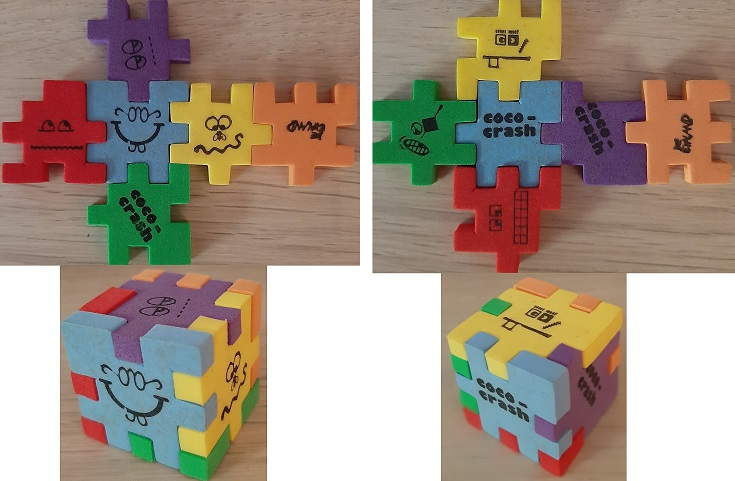

In [23]:
Image(filename='img\Solutions.jpg', width=400)